In [339]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

### what is done:
construct Wikispeedia graph
run page rank
process the 'finished paths': 
    <br> - take into account back clicks to consider only the effective path
    <br> - 'processed_paths' contains all the finished paths starting from the 'hub' (the page with highest page rank in that path)


#### see next step at the bottom

##### please update this cell to keep track of prject progress

###  1 -  Data Overview and Pre-processing
## *********************************************************************************************************

In [340]:
links = pd.read_csv("wikispeedia_paths-and-graph/links.tsv", sep='\t', skiprows = 11, names = ['link_source', 'link_target'])
# links.tsv contains all links between articles. It can be used to contruct a graph

In [341]:
#verify that there is no missing source/target
links.any().isna()

link_source    False
link_target    False
dtype: bool

In [342]:
articles_graph = nx.from_pandas_edgelist(links, 'link_source', 'link_target', create_using=nx.DiGraph())

In [343]:
dangling_nodes = []
for node, out_deg in articles_graph.out_degree():
    if out_deg == 0:
        dangling_nodes.append(node)
        
dangling_nodes

['Osteomalacia',
 'Local_community',
 'Directdebit',
 'Duchenne_muscular_dystrophy',
 'Klinefelter%27s_syndrome']

In [344]:
page_rank = nx.pagerank(articles_graph, alpha = 0.95)

In [345]:
keys = list(page_rank.keys())
vals = list(page_rank.values())
sorted_page_rank = {keys[i]: vals[i] for i in np.argsort(vals)[::-1]}

In [346]:
#At this step page rank is done for each page
# now we would like to consider the paths ....

In [347]:
finished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress','timestamp','durationInSec','path','rating'])
unfinished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress' ,  'timestamp' ,  'durationInSec' ,  'path' ,  'target'   ,'type'])

In [348]:
finished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN


In [349]:
unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [350]:

#final version of remove_unvisited_pages
# working well enfiiin

def remove_unvisited_pages(path):
    if path.count('<') == 0:
        return path
    
    i=0
    while i<len(path):

        if path[i] == '<':
        
            counter = 0
            tmp_i = i

            while tmp_i<len(path) and path[tmp_i] == '<':
       
                tmp_i +=1
                counter+=1
            v=max(0,i-counter)

            for j in range(v, i):

                path[j] = '<'
            i = tmp_i
        else:
            i+=1
    indx = np.where(np.array(path)=='<')[0]
    path = np.delete(np.array(path), indx)
    return path

In [351]:
#test remove_unvisited_pages
l =(finished_paths['path'].iloc[40]).split(';')
print(l)           
l=remove_unvisited_pages(l)
l

['14th_century', 'Europe', '<', 'England', '<', 'Christianity', 'Anglicanism', 'United_States', 'Walt_Whitman', '<', 'Poetry_of_the_United_States', '<', '<', '<', 'French_Revolution', 'Age_of_Enlightenment', 'David_Hume', 'Philosophy', 'Fyodor_Dostoevsky', '<', '<', '<', '<', 'Constitutional_monarchy', 'Government', 'Anarchism', 'Henry_David_Thoreau']


array(['14th_century', 'Christianity', 'Anglicanism', 'United_States',
       'French_Revolution', 'Constitutional_monarchy', 'Government',
       'Anarchism', 'Henry_David_Thoreau'], dtype='<U23')

In [352]:
def process_paths(paths,processed_paths,pages_with_no_rank,upPath = True) :
    for i, s in paths.iterrows():
        path_split=(paths['path'].iloc[i]).split(';')
        path_split = remove_unvisited_pages(path_split)
        ranks = []
        for elem in path_split:
            r = page_rank.get(elem, -1)
            if r==-1:
                pages_with_no_rank.append(elem)
            ranks.append(r)
        if upPath : 
            processed_paths.append(path_split[:np.argmax(ranks)])
        else : 
            processed_paths.append(path_split[np.argmax(ranks) :])


In [353]:
#processed paths contains all the paths starting from the 'hub'  or up to the 'hub'

In [354]:
processed_finished_paths_upPath = []
pages_with_no_rank_finished_paths_upPath = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(finished_paths,processed_finished_paths_upPath,pages_with_no_rank_finished_paths_upPath)  

processed_finished_paths_downPath = []
pages_with_no_rank_finished_paths_downPath = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(finished_paths,processed_finished_paths_downPath,pages_with_no_rank_finished_paths_downPath, upPath=False)  


In [355]:
processed_unfinished_paths_upPath = []
pages_with_no_rank_unfinished_paths_upPath = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(unfinished_paths,processed_unfinished_paths_upPath,pages_with_no_rank_unfinished_paths_upPath)  

processed_unfinished_paths_downPath = []
pages_with_no_rank_unfinished_paths_downPath = []  # those pages are missing in 'articles' ?! Should we add them to the graph ?
process_paths(unfinished_paths,processed_unfinished_paths_downPath,pages_with_no_rank_unfinished_paths_downPath, upPath=False)  

In [356]:
categories = pd.read_csv("wikispeedia_paths-and-graph/categories.tsv", sep='\t', skiprows = 12, names=['article', 'category'])

In [357]:
categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [358]:
# the number of periods is the specifity of the category, the more specific 
# the more relevant 
def count_periods(s):
    return s.count('.')

In [359]:
# column with the count of periods in the category
categories['period_count'] = categories['category'].apply(count_periods)

# most specific category for each article
most_specific_category = categories.sort_values(by='period_count', ascending=False).drop_duplicates('article')
specific_categories = most_specific_category.drop(columns=['period_count'])

# here we reset the index
specific_categories.reset_index(drop=True, inplace=True)

specific_categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,European_Greenfinch,subject.Science.Biology.Birds
2,Rutherfordium,subject.Science.Chemistry.Chemical_elements
3,Eurasian_Oystercatcher,subject.Science.Biology.Birds
4,Eurasian_Jay,subject.Science.Biology.Birds


In [360]:
# making the article column the index
specific_categories = specific_categories.set_index('article')

In [361]:
specific_categories.head()

,category
article,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
European_Greenfinch,subject.Science.Biology.Birds
Rutherfordium,subject.Science.Chemistry.Chemical_elements
Eurasian_Oystercatcher,subject.Science.Biology.Birds
Eurasian_Jay,subject.Science.Biology.Birds


### 2 - Analyse finished Paths Behavior
## ************************************************************************************************************************

### 2-1 Finished Paths - UpPath

In this part , we will  be directed towards the "Up Paths" segment of the succesfully finished paths. Specifically, we will utilize all the transitions leading up to the hub (estimated as the article with  the maximum page rank score)for each path. This information was previously calculated in the preceding section. Our objective here is to confirm whether the trend within this initial portion of the transitions involves links from a specific category to a more general one, in order to attain some hub.

In [362]:
from collections import defaultdict

# building the connection dataframe with the counter
def build_category_connections(category_paths) :
    category_pairs_counter = defaultdict(int)

    # Process each path
    for path in category_paths:
        for i in range(len(path) - 1):
            # Increment the counter for each found pair
            pair = (path[i], path[i + 1])
            category_pairs_counter[pair] += 1

    # unique category list that appear in our paths, 
    # no need for all categories of articles in  

    unique_categories = list(set(cat for path in category_paths for cat in path))

    # Initialize an the connections
    category_connections = pd.DataFrame(index=unique_categories, columns=unique_categories).fillna(0)

    # filling up the values with the counts
    for (cat1, cat2), count in category_pairs_counter.items():
        category_connections.loc[cat1, cat2] = count
    
    return category_connections

In [363]:
def count_words(index):
    return len(index.split('.'))

In [364]:
def heatmap_general_categories(category_connections) :
    df = category_connections.copy() 
    
    #Remove 'subject.' prefix since it is common to all categories
    df.index = df.index.str.replace('subject.', '')
    df.columns = df.columns.str.replace('subject.', '')
    
    # Sort the dataframe based on the number of words in ascending order, this will be useful to  keep only general categories
    df['WordCount'] = df.index.map(count_words)
    df_sorted = df.sort_values(by='WordCount', ascending = False)
    df_sorted = df_sorted.drop(columns='WordCount')
    
    index_order = df_sorted.index.tolist()
    # Reorder the columns based on the order of the index
    df_sorted = df_sorted.reindex(columns=index_order)

    #regroup all columns that have a common prefix, to  keep only general categories
    for ind1,row1 in df_sorted.iterrows() :
        for ind2,row2 in df_sorted.iterrows() :
            if ind1.split('.')[0] == ind2.split('.')[0] :
                for ind3,row3 in df_sorted.iterrows() :
                    df_sorted.loc[ind3,ind1] += df_sorted.loc[ind3,ind2]
                    df_sorted.loc[ind1,ind3]+= df_sorted.loc[ind2,ind3]
                break
    iter1=0         
    for ind1,row1 in df_sorted.iterrows() :
            iter2=0
            for ind2,row2 in df_sorted.iterrows():
                if ind1!=ind2 and ind1.split('.')[0] == ind2.split('.')[0] and iter2<iter1 :
                    df_sorted = df_sorted.drop(columns = ind1)
                    df_sorted= df_sorted.drop(index=ind1)
                    break
                iter2+=1
            iter1+=1
        
        

    new_index = df_sorted.index.str.split('.').str.get(0)

    # Replace the index with the new_index i.e the general one for each category
    df_sorted.index = new_index
    
    # Replace the columns with the new_columns
    new_columns = df_sorted.columns.str.split('.').str.get(0)
    df_sorted.columns = new_columns
    df = df_sorted.reindex(df.index, axis=1)
    
    #drop unknown_category
    df = df_sorted.drop(columns="Unknown_Category")
    df = df.drop(index = "Unknown_Category")
    
    
    # dropping all values in the diagonal since transitions in the same categories are useless for our purpose
    np.fill_diagonal(df.values, 0)
    
    #plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True)
    plt.title('Heatmap of Weights between Categories')
    plt.show()    

In [365]:
#Now we can also focus only on categories that belong to a  General Category such as Science or History... 
def heatMap_Special_Category(category,category_connections) : 
    
    df = category_connections.copy() 
    
    #Remove 'subject.' prefix again
    df.index = df.index.str.replace('subject.', '')
    df.columns = df.columns.str.replace('subject.', '')
    #filtering   all the categories to keep only those that belong to the general one
    df = df.filter(like=category, axis=1).filter(like=category, axis=0)
    
    #Again dropping all the diagonal values for the same reasons as before
    np.fill_diagonal(df.values, 0)
    
    #Plotting the heatMap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", cbar=True)
    plt.title('Heatmap of Weights between Categories of %s' %category)
    plt.show()   

In [366]:
# transforming the article paths into paths of categories for the UpPath Part of the finished paths 
processed_finished_paths_serie = pd.Series(processed_finished_paths_upPath)
category_finished_paths_upPath = processed_finished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_finished_paths_upPath.head()

0                    [subject.History.General_history]
1    [subject.History.General_history, subject.Geog...
2    [subject.History.General_history, subject.Hist...
3                    [subject.History.General_history]
4    [subject.History.General_history, subject.Geog...
dtype: object

In [367]:
#build category connections 
category_connections_finished_paths_upPath = build_category_connections(category_finished_paths_upPath)
category_connections_finished_paths_upPath

,subject.History.Recent_History,subject.Religion.Myths,subject.Everyday_life.Drink,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Language_and_literature.Poetry_and_Opera,subject.Science.Physics.General_Physics,subject.Geography.Climate_and_the_Weather,subject.Everyday_life.Films,subject.IT.Software,subject.Geography.Mineralogy,...,subject.Geography.Geography_of_Great_Britain,subject.Geography.African_Geography.African_Countries,subject.Design_and_Technology.Railway_transport,subject.Science.Biology.Health_and_medicine,subject.History.North_American_History,subject.People.Producers_directors_and_media_figures,subject.History.British_History.British_History_Post_1900,subject.Everyday_life.Food_and_agriculture,subject.History.Historians_chroniclers_and_history_books,subject.Science.Biology.Plants
subject.History.Recent_History,30,0,0,2,0,2,0,1,0,1,...,4,3,5,3,0,0,5,3,0,0
subject.Religion.Myths,0,52,1,0,1,0,2,1,0,0,...,14,0,0,0,0,0,0,1,1,0
subject.Everyday_life.Drink,0,0,18,1,0,0,18,0,0,0,...,6,10,0,5,0,0,1,29,0,28
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,0,0,6,68,1,3,1,0,0,0,...,5,9,0,4,0,0,5,16,0,9
subject.Language_and_literature.Poetry_and_Opera,0,0,0,0,18,0,0,1,0,0,...,8,0,0,2,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Producers_directors_and_media_figures,0,1,0,0,0,0,0,6,0,0,...,4,0,0,11,0,0,3,0,0,0
subject.History.British_History.British_History_Post_1900,5,0,0,4,0,0,0,0,0,0,...,17,1,1,3,0,0,10,0,0,0
subject.Everyday_life.Food_and_agriculture,0,1,21,9,0,10,22,0,0,0,...,10,9,0,35,0,0,0,134,0,88
subject.History.Historians_chroniclers_and_history_books,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


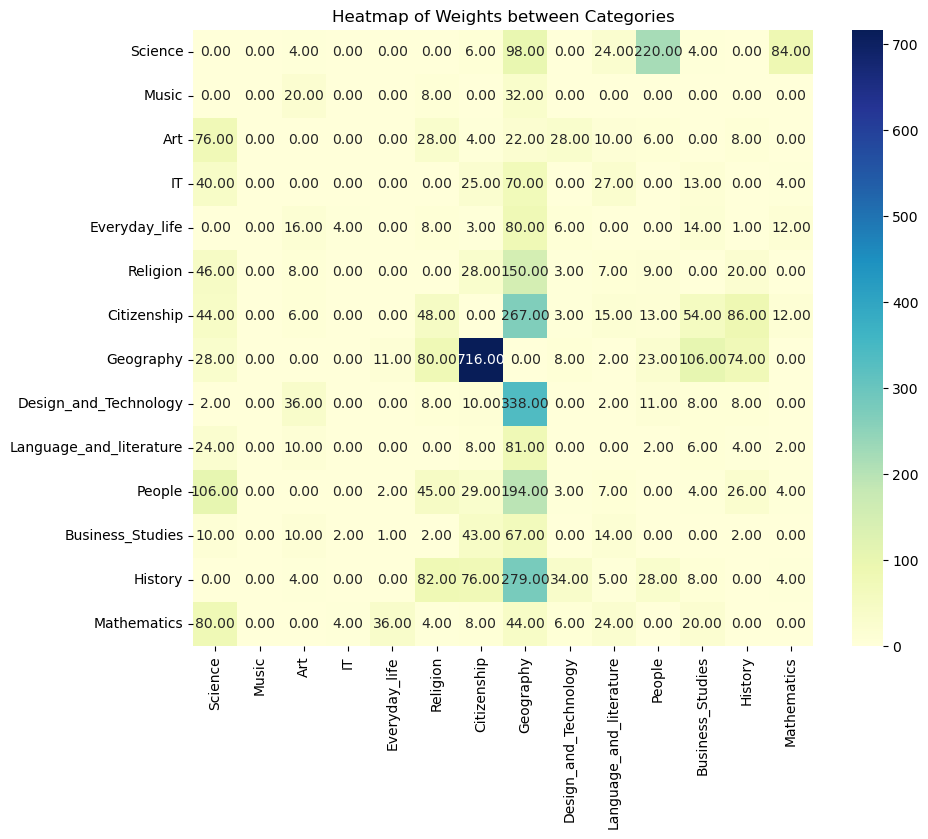

In [368]:
heatmap_general_categories(category_connections_finished_paths_upPath)

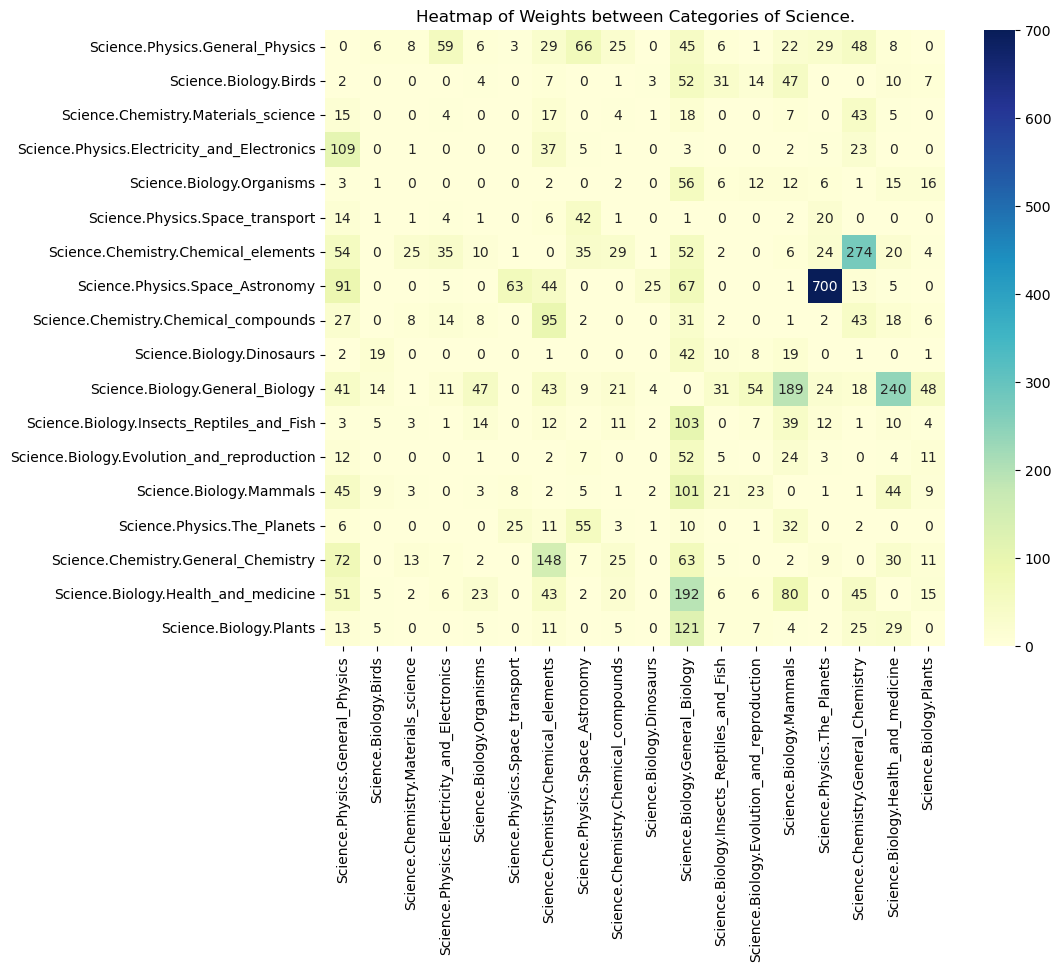

In [369]:
heatMap_Special_Category("Science.",category_connections_finished_paths_upPath)

### 2-2 Finished Paths - DownPath

In this part , we will  focus on the "Down Paths" segment of the succesfully finished paths. Specifically, we will utilize all the transitions starting from the hub up to the final destination.Since we disovered in the previous sub-section that the first 'Up Path' segment lead to a general category in general(corresponding to the category of the hub), we will be expecting to find that the Down Path(i.e the second part of the transitions) generally involves links from  general category to a specific one.

In [370]:
# transforming the article paths into paths of categories for the downPath Part of the finished paths 
category_finished_paths_downPath = processed_finished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_finished_paths_downPath.head()

0    [subject.Geography.European_Geography, subject...
1    [subject.Geography.African_Geography, subject....
2    [subject.Geography.European_Geography.European...
3    [subject.Geography.European_Geography.European...
4    [subject.Geography.North_American_Geography, s...
dtype: object

In [371]:
#build category connections 
category_connections_finished_paths_downPath = build_category_connections(category_finished_paths_downPath)
category_connections_finished_paths_downPath

,subject.History.Recent_History,subject.Religion.Myths,subject.Everyday_life.Drink,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Language_and_literature.Poetry_and_Opera,subject.Science.Physics.General_Physics,subject.Geography.Climate_and_the_Weather,subject.Everyday_life.Films,subject.IT.Software,subject.Geography.Mineralogy,...,subject.Geography.Geography_of_Great_Britain,subject.Geography.African_Geography.African_Countries,subject.Design_and_Technology.Railway_transport,subject.Science.Biology.Health_and_medicine,subject.History.North_American_History,subject.People.Producers_directors_and_media_figures,subject.History.British_History.British_History_Post_1900,subject.Everyday_life.Food_and_agriculture,subject.History.Historians_chroniclers_and_history_books,subject.Science.Biology.Plants
subject.History.Recent_History,83,0,0,0,0,0,0,0,0,1,...,8,4,0,1,0,0,7,0,0,4
subject.Religion.Myths,0,46,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,3,0
subject.Everyday_life.Drink,0,0,39,4,0,0,6,0,0,0,...,3,0,0,4,0,0,0,131,0,38
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,6,0,20,266,0,1,4,2,0,1,...,2,2,0,2,0,0,6,78,0,41
subject.Language_and_literature.Poetry_and_Opera,0,2,0,0,62,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Producers_directors_and_media_figures,0,0,0,0,0,0,0,4,0,0,...,0,0,0,1,0,0,0,0,0,0
subject.History.British_History.British_History_Post_1900,105,0,0,11,0,0,3,0,0,0,...,25,34,1,0,0,0,180,0,0,0
subject.Everyday_life.Food_and_agriculture,0,0,121,6,1,50,35,0,0,1,...,3,2,0,77,0,0,0,1029,0,1004
subject.History.Historians_chroniclers_and_history_books,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


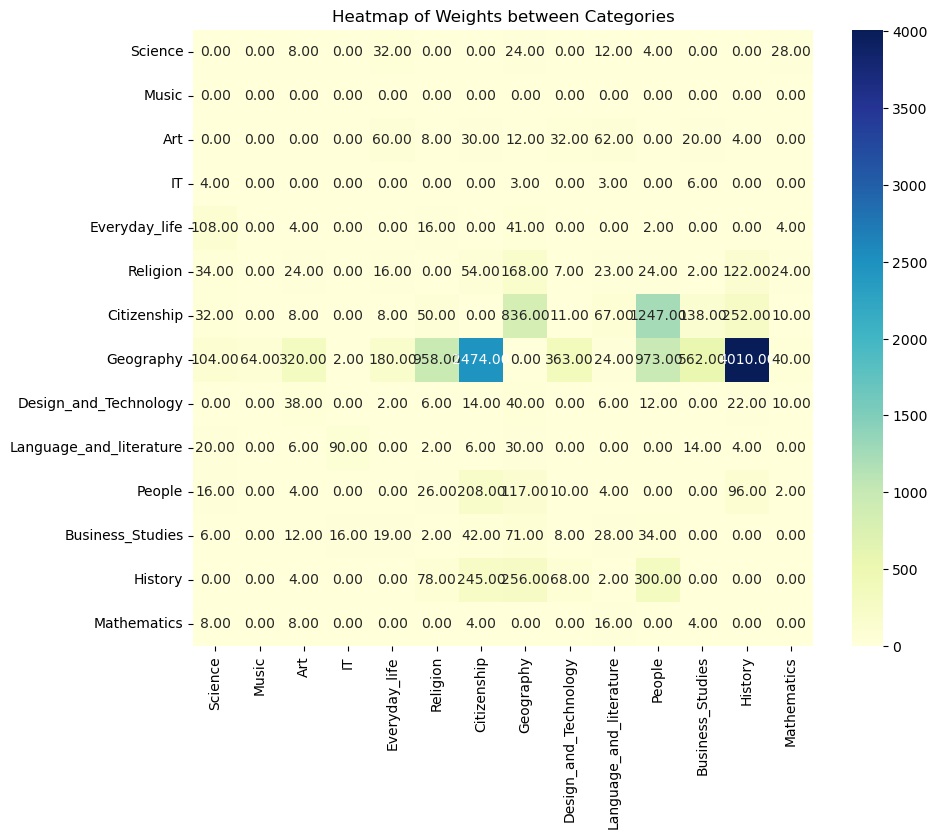

In [372]:
heatmap_general_categories(category_connections_finished_paths_downPath)

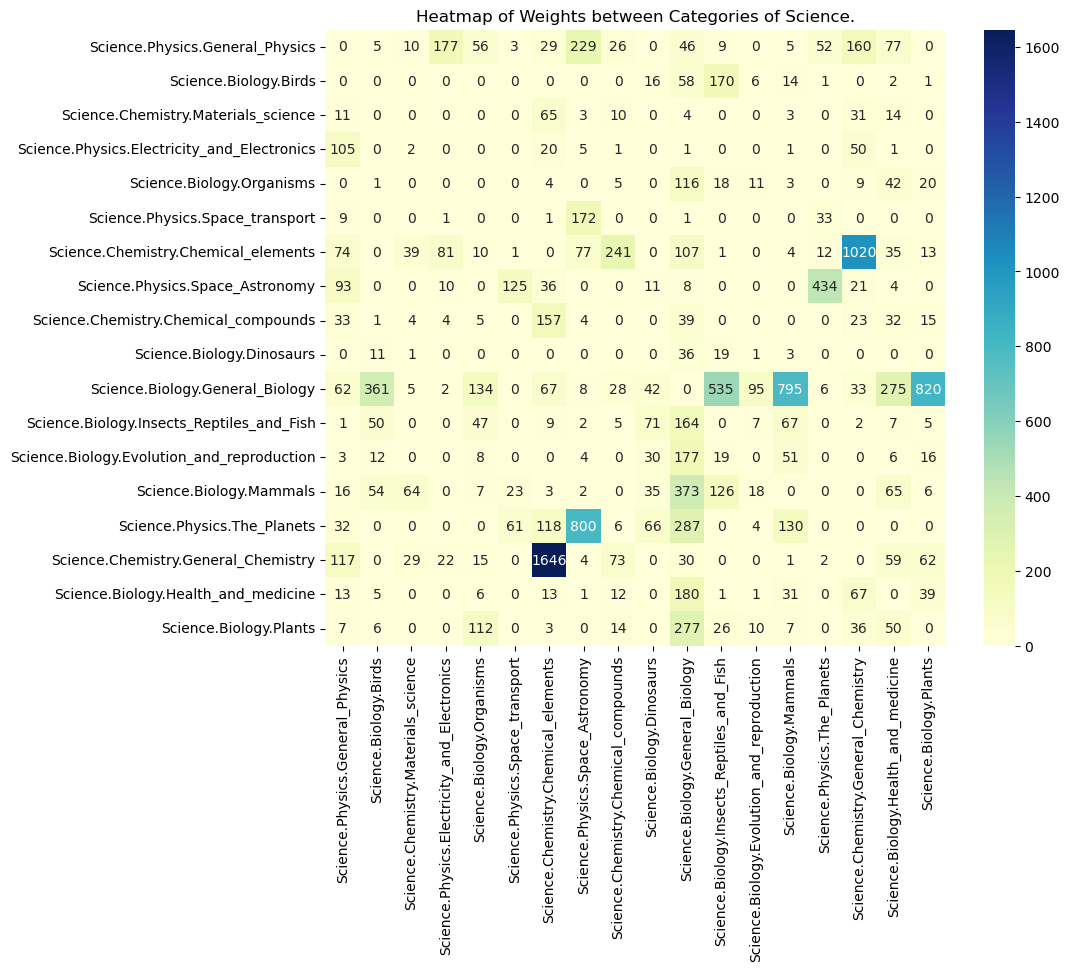

In [373]:
heatMap_Special_Category("Science.",category_connections_finished_paths_downPath)

### 3 - Analyse Unfinished Paths Behavior
## ************************************************************************************************************************

### 3-1 Unfinished Paths - UpPath

In this sub-part, we conduct a similar analysis of the "UpPath" as we did previously for the completed paths, but this time focusing on the unfinished paths. This approach will allow us to  explore the important differences between successful and unsuccessful paths.

In [374]:
# transforming the article paths into paths of categories for the UpPath Part of the unfinished paths 
category_unfinished_paths_upPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_upPath.head()

0                                                   []
1                                                   []
2    [subject.Geography.African_Geography.African_C...
3                                                   []
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [375]:
#build category connections 
category_connections_unfinished_paths_upPath = build_category_connections(category_unfinished_paths_upPath)
category_connections_unfinished_paths_upPath

,subject.History.Recent_History,subject.Religion.Myths,subject.Everyday_life.Drink,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Language_and_literature.Poetry_and_Opera,subject.Science.Physics.General_Physics,subject.Geography.Climate_and_the_Weather,subject.Everyday_life.Films,subject.IT.Software,subject.Geography.Mineralogy,...,subject.Geography.Geography_of_Great_Britain,subject.Geography.African_Geography.African_Countries,subject.Design_and_Technology.Railway_transport,subject.Science.Biology.Health_and_medicine,subject.History.North_American_History,subject.People.Producers_directors_and_media_figures,subject.History.British_History.British_History_Post_1900,subject.Everyday_life.Food_and_agriculture,subject.History.Historians_chroniclers_and_history_books,subject.Science.Biology.Plants
subject.History.Recent_History,12,0,0,0,0,0,0,0,0,1,...,1,1,1,1,0,0,1,1,0,0
subject.Religion.Myths,0,9,0,0,0,0,2,6,0,0,...,4,0,0,0,0,0,0,0,0,0
subject.Everyday_life.Drink,0,0,4,0,0,0,7,0,0,0,...,2,2,0,4,0,0,1,13,0,9
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,0,0,1,25,0,0,0,0,0,0,...,0,2,0,0,0,0,5,5,0,4
subject.Language_and_literature.Poetry_and_Opera,0,0,0,0,13,0,0,0,0,0,...,4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Producers_directors_and_media_figures,0,0,0,0,0,0,0,0,0,0,...,3,0,0,1,0,0,0,0,0,0
subject.History.British_History.British_History_Post_1900,2,0,0,2,0,1,0,0,0,0,...,11,0,0,1,0,0,7,0,0,0
subject.Everyday_life.Food_and_agriculture,0,0,9,3,0,1,8,0,0,4,...,6,1,0,10,0,0,0,71,0,51
subject.History.Historians_chroniclers_and_history_books,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


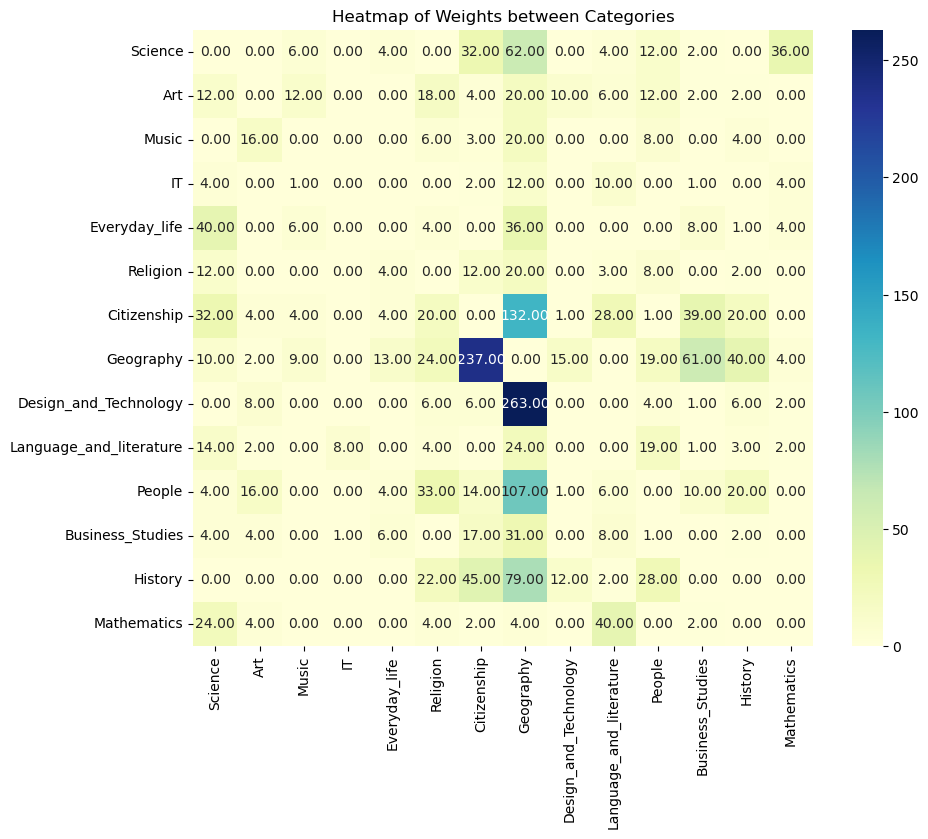

In [376]:
heatmap_general_categories(category_connections_unfinished_paths_upPath)

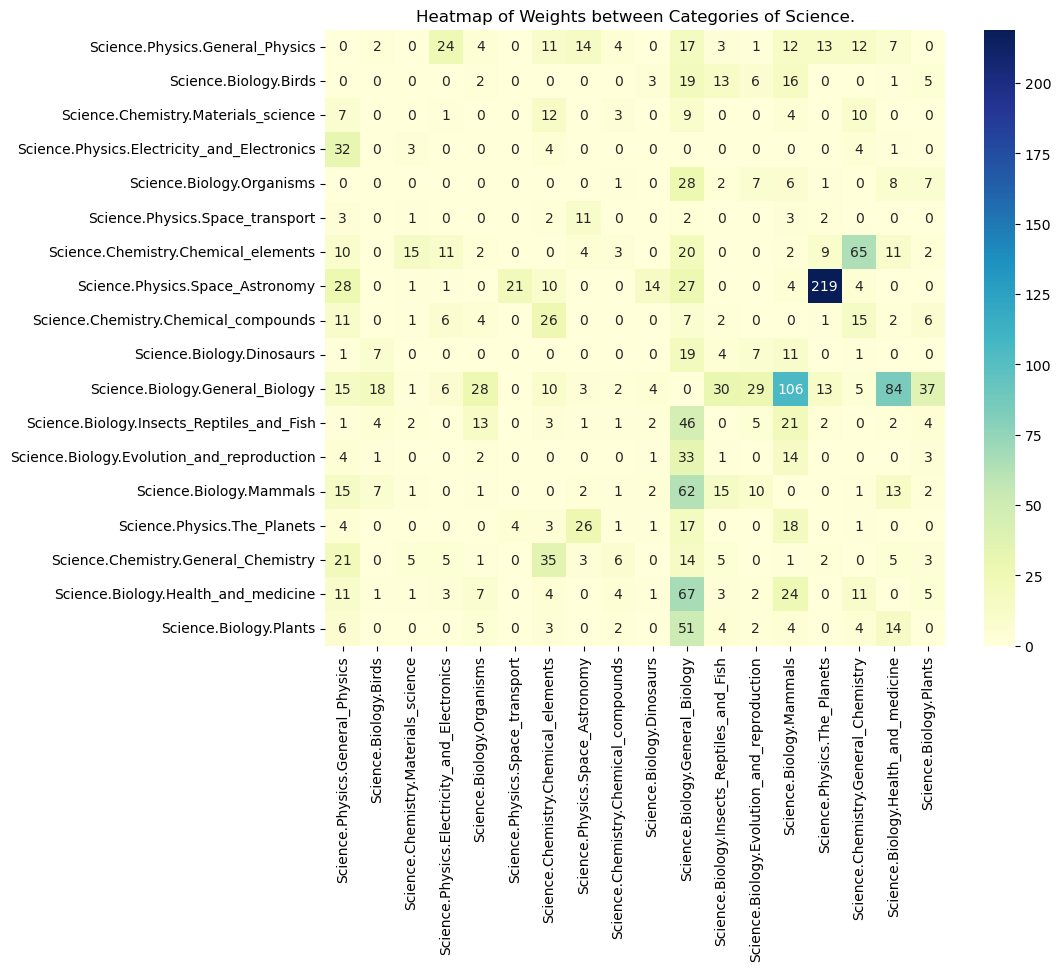

In [377]:
heatMap_Special_Category("Science.",category_connections_unfinished_paths_upPath)

### 3-2 Unfinished Paths - DownPath

In this subsection , We will conduct the same analysis for the DownPath of the  unfinished paths as we did for the finished paths. Given that we observed the same behavior in both paths for the UpPath segment during the previous subsection, we expect that the finished and unfinished paths both have the same behavior also for the DownPath, which means that we will observe links generally going from a general category to a more specific one.

In [378]:
# transforming the article paths into paths of categories  
processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths_downPath)
category_unfinished_paths_downPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_downPath.head()

0                        [subject.Everyday_life.Films]
1                  [subject.People.Historical_figures]
2    [subject.Citizenship.Politics_and_government, ...
3    [subject.Geography.Central_and_South_American_...
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [379]:
#Build category connections
category_connections_unfinished_paths_downPath = build_category_connections(category_unfinished_paths_downPath)
category_connections_unfinished_paths_downPath

,subject.History.Recent_History,subject.Religion.Myths,subject.Everyday_life.Drink,subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,subject.Language_and_literature.Poetry_and_Opera,subject.Science.Physics.General_Physics,subject.Geography.Climate_and_the_Weather,subject.Everyday_life.Films,subject.IT.Software,subject.Geography.Mineralogy,...,subject.Geography.Geography_of_Great_Britain,subject.Geography.African_Geography.African_Countries,subject.Design_and_Technology.Railway_transport,subject.Science.Biology.Health_and_medicine,subject.History.North_American_History,subject.People.Producers_directors_and_media_figures,subject.History.British_History.British_History_Post_1900,subject.Everyday_life.Food_and_agriculture,subject.History.Historians_chroniclers_and_history_books,subject.Science.Biology.Plants
subject.History.Recent_History,35,0,0,1,0,0,0,0,0,0,...,1,0,0,2,0,0,4,0,0,1
subject.Religion.Myths,0,28,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
subject.Everyday_life.Drink,0,0,7,6,0,0,6,0,0,0,...,0,2,0,2,0,0,0,27,0,11
subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries,0,0,11,79,0,0,0,1,0,0,...,1,5,0,1,0,0,1,18,0,9
subject.Language_and_literature.Poetry_and_Opera,0,1,0,0,11,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Producers_directors_and_media_figures,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,4,0,0,0,0
subject.History.British_History.British_History_Post_1900,19,0,0,2,0,0,0,0,0,0,...,12,11,0,0,0,0,35,0,0,0
subject.Everyday_life.Food_and_agriculture,0,0,43,5,0,7,22,0,0,0,...,2,1,0,28,0,0,0,370,0,192
subject.History.Historians_chroniclers_and_history_books,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


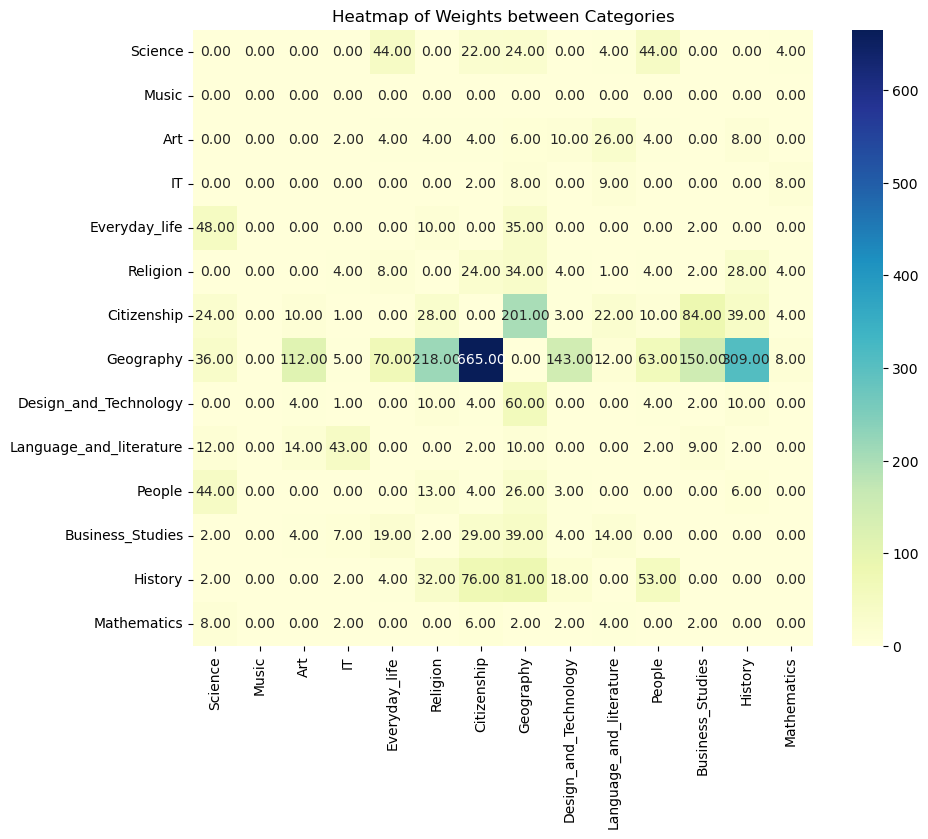

In [380]:
heatmap_general_categories(category_connections_unfinished_paths_downPath)

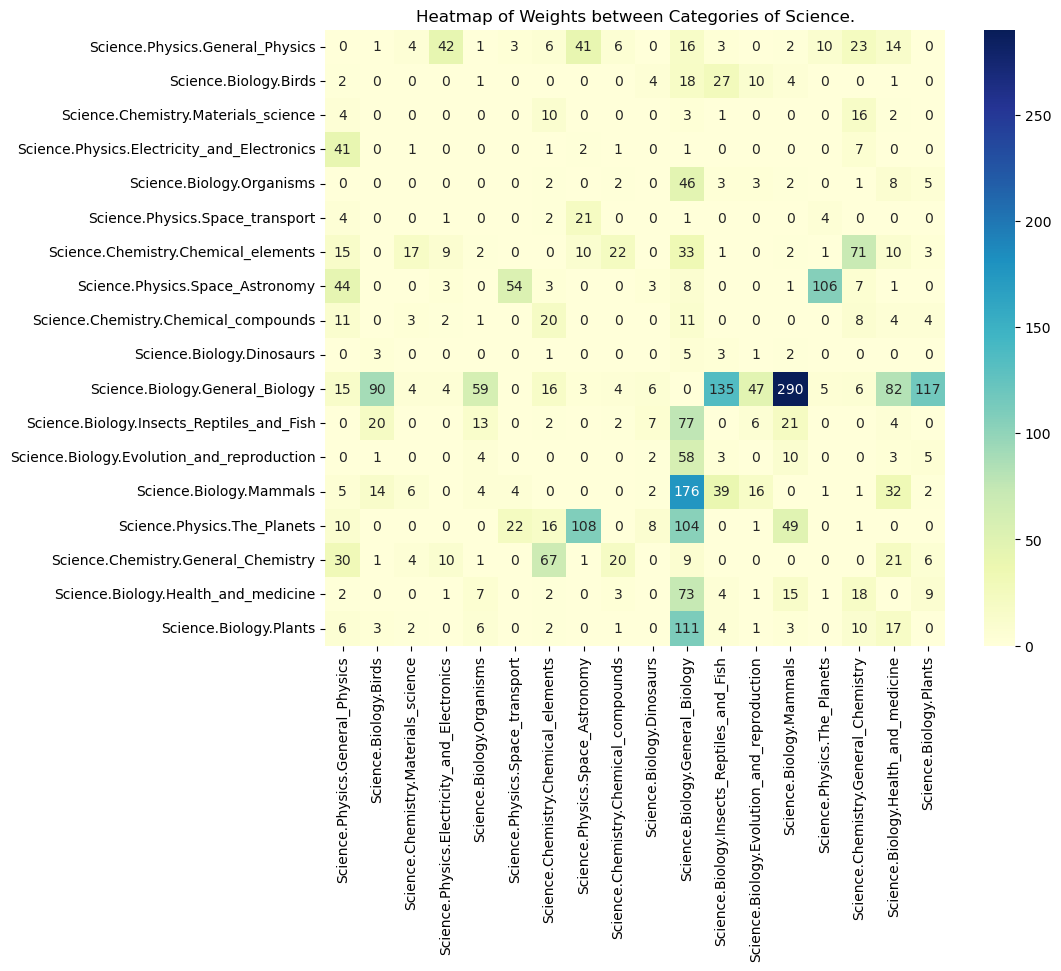

In [381]:
heatMap_Special_Category("Science.",category_connections_unfinished_paths_downPath)

### 3 - Compare destinations of finished and unfinished Paths
## ************************************************************************************************************************

In the previous part, we observed that both finished and unfinshed paths have exactly the same pattern : i.e  the first segment (UpPath) of the path

generaly escapes from specific categories to more general ones, up until  a hub, then the second segment(DownPath) links have tendency to go from general categories to more specific ones ,  this suggests that the difference between finished and unfinshed paths is not really the starting point , since we can reach a hub starting from anyhub, but the main difference might be in the final destination article, in this section we will try to analyse differences between the destinations of both finished and unfinished paths by comparing the distribution of their in-degrees.
    

In [382]:
#we recover all the in-degrees of the destinations of the unfinished paths
unfinished_paths_in_degrees = unfinished_paths["target"].apply(lambda t: G.in_degree(t)).fillna(0).apply(lambda t : t if isinstance(t, (int)) else 0) + 1 
#we recover all the in-degrees of the destinations of the finished paths
finished_paths_in_degrees = finished_paths["path"].apply(lambda t : G.in_degree(t.split(";")[-1])).apply(lambda t : t if isinstance(t, (int)) else 0) +1


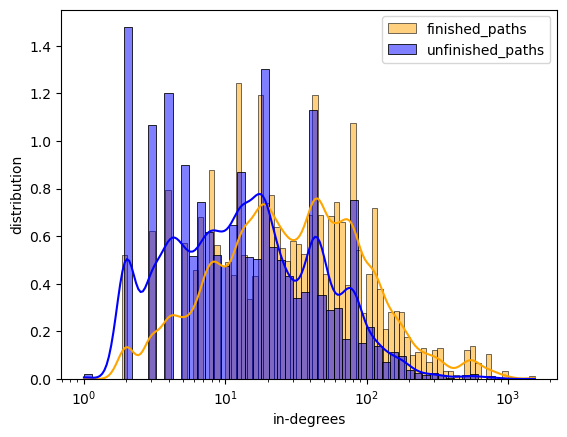

In [384]:
# plotting the distributions of the in-degrees of destinations for both finished and unfinished_paths
ax = sns.histplot(finished_paths_in_degrees, kde=True, stat='density', color='orange', label='finished_paths',log_scale=True)
ax = sns.histplot(unfinished_paths_in_degrees, kde=True, stat='density', color='blue', label='unfinished_paths',log_scale=True)
plt.legend()
plt.ylabel("distribution")
plt.xlabel("in-degrees")
plt.show()

In this histogram, it is clear  that the destinations of unfinished paths are more likely to have lower in-degrees, indicating greater difficulty in reaching those destinations. Also, we can see that  starting from an in-degree of 20 degrees, the destinations of finished paths have a  higher probability. This observation aligns with intuition, as higher in-degrees suggest increased popularity of an article, making it more accessible and easier to reach.